In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans

In [9]:
# 1. Load the dataset (replace with your dataset path if local)
url = "https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv"
df = pd.read_csv(url)

# Basic EDA and data cleaning
print("Dataset overview:")
print(df.head())
print(df.info())
print(df.describe())


Dataset overview:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26   

In [10]:
# 2. Basic Data Exploration
print("Dataset Info:\n")
print(df.info())
print("\nSummary Statistics:\n")
print(df.describe())


Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64


In [11]:
# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing values:\n", missing_values)

# Fill missing values or drop columns with excessive missing data
df = df.fillna(df.median())




Missing values:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


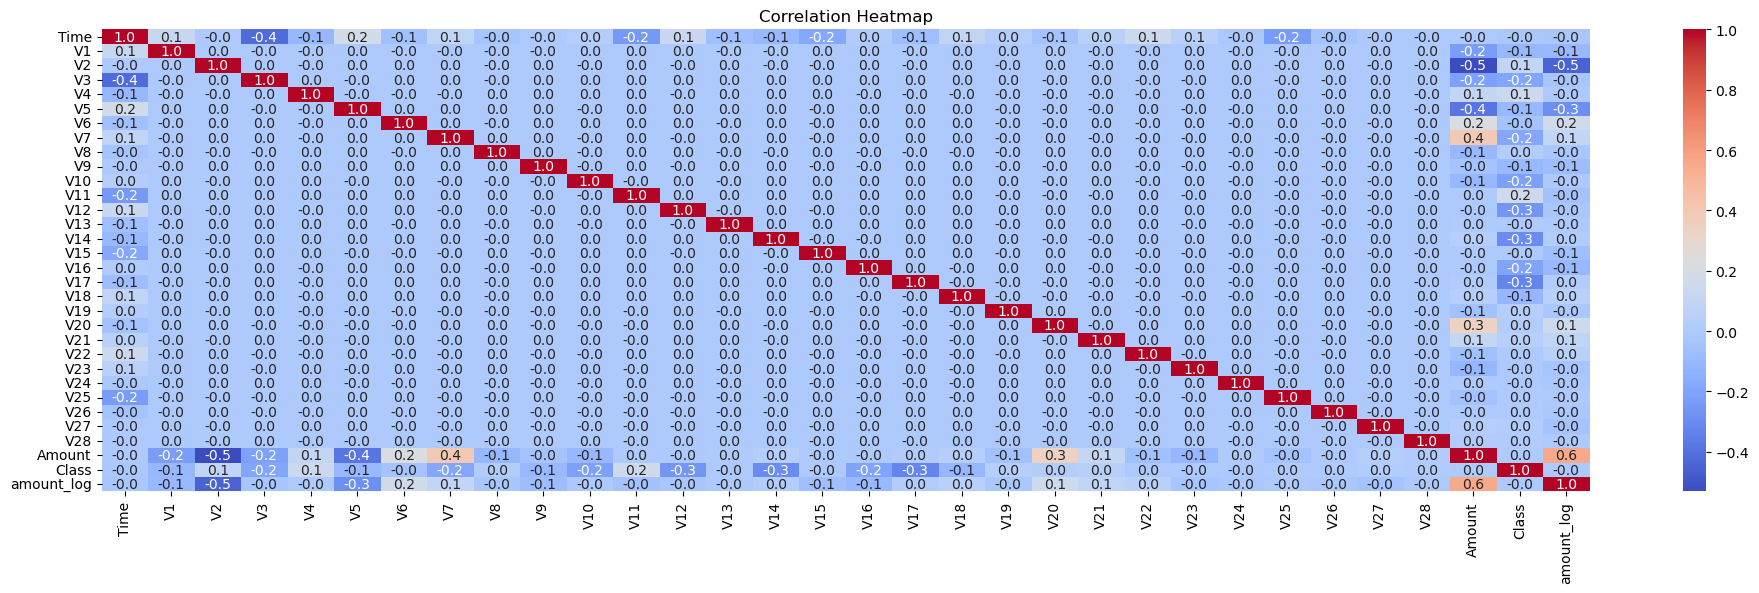

In [18]:
# Feature engineering: creating additional features
df['amount_log'] = np.log1p(df['Amount'])  # Log transformation for skewed data

# Correlation heatmap
plt.figure(figsize=(24, 6))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".1f")
plt.title("Correlation Heatmap")
plt.show()

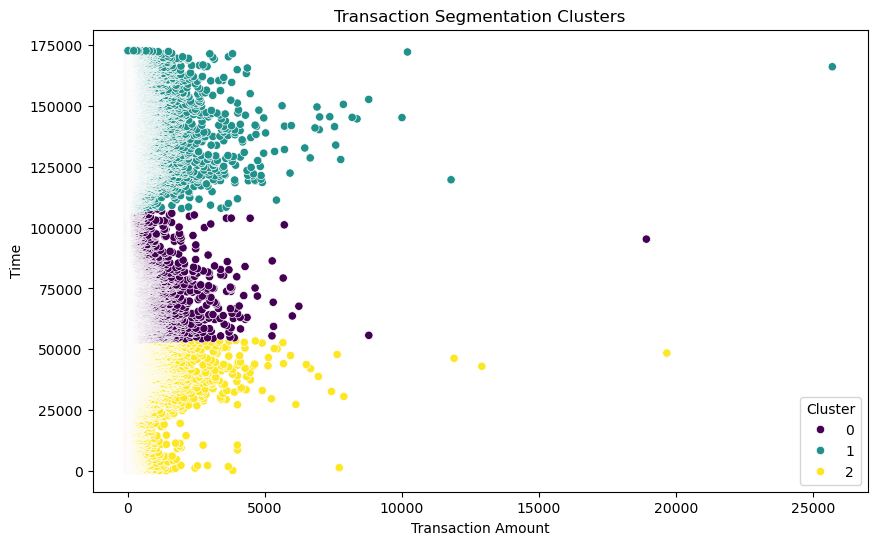

In [19]:
# Clustering for transaction segmentation
features = ['Amount', 'Time']
X = df[features]
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Amount', y='Time', hue='cluster', palette='viridis')
plt.title("Transaction Segmentation Clusters")
plt.xlabel("Transaction Amount")
plt.ylabel("Time")
plt.legend(title="Cluster")
plt.show()

# Preparing data for fraud detection model
X = df.drop(['Class', 'Time'], axis=1)  # 'Class' is the target variable
y = df['Class']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Train Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid_search = GridSearchCV(rf_model, param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_


In [20]:
print(best_model)

RandomForestClassifier(max_depth=20, n_estimators=200, random_state=42)


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.92      0.82      0.86       136

    accuracy                           1.00     85443
   macro avg       0.96      0.91      0.93     85443
weighted avg       1.00      1.00      1.00     85443



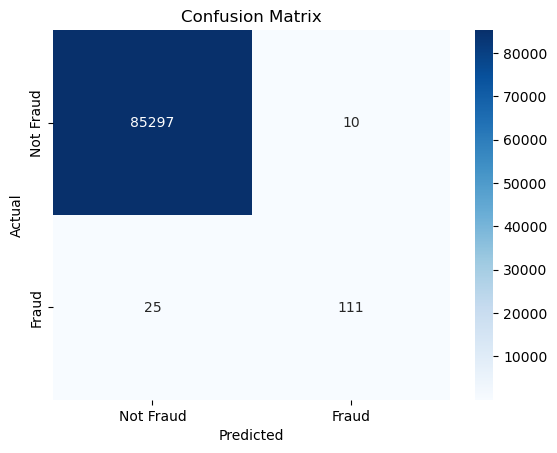

In [21]:
# Evaluate the model
y_pred = best_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

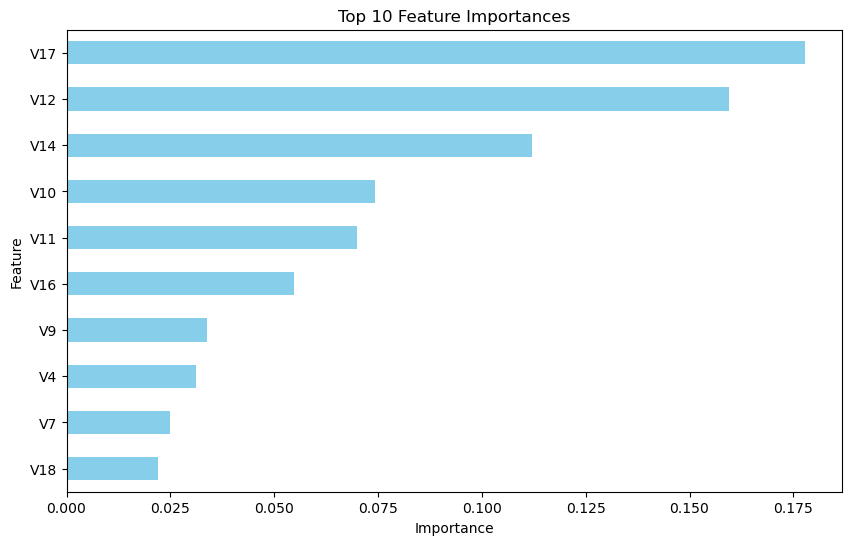

In [22]:
# Feature importance visualization
feature_importances = pd.Series(best_model.feature_importances_, index=df.drop(['Class', 'Time'], axis=1).columns)
feature_importances.nlargest(10).sort_values().plot(kind='barh', color='skyblue', figsize=(10, 6))
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

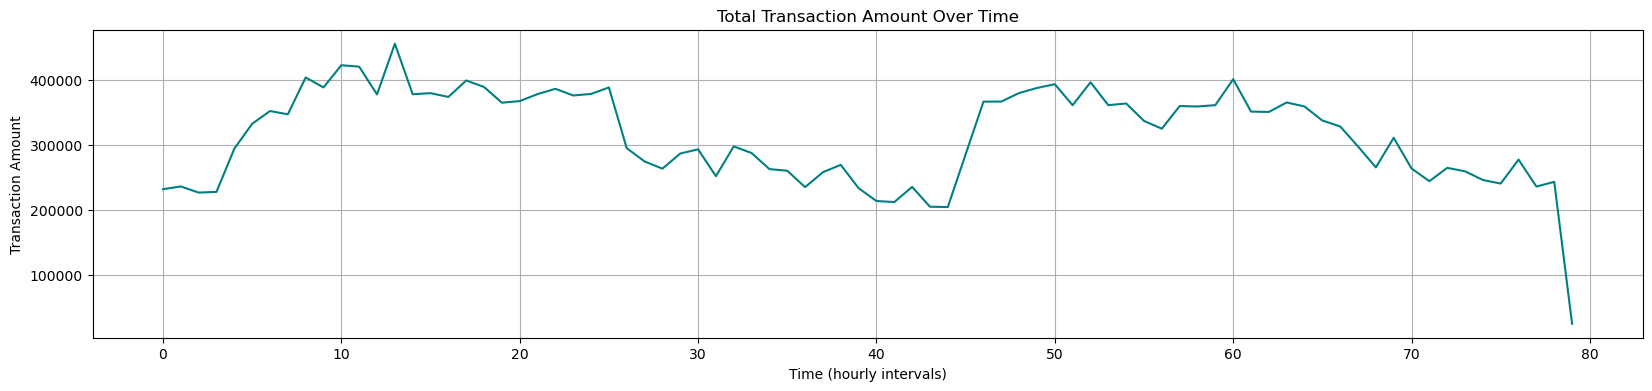

In [ ]:
# Time-series visualization of transactions
time_series_data = df.groupby(df.index // (60 * 60))['Amount'].sum()  # Aggregating per hour
time_series_data.plot(figsize=(20, 4), color='teal')
plt.title("Total Transaction Amount Over Time")
plt.xlabel("Time (hourly intervals)")
plt.ylabel("Transaction Amount")
plt.grid()
plt.show()